# Carmi and John Go for a Walk

*An exploration of movie data using SQL*

This book will examine movies along the following parameters:

-**Worldwide gross**:  
--domestic vs. foreign  
-**Film personnel**:  
--by talent  
--by director  
--by writer  
-**Film characteristics**:  
--by genre  
--by rating  
--by runtime  
--by release date

We begin by importing all the requisite libraries and setting up the MySQL connection.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
%matplotlib inline

conn = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

## Genre (John)

*What is the impact of genre on box office sales?*

Which genres make the most at the box office?

In [2]:
df = pd.read_sql_query('''
    SELECT movie,
           start_year,
           runtime_minutes,
           genres,
           CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS productionBudget, 
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) AS worldwideGross
    FROM imdb_title_basics
    JOIN tn_movie_budgets
    ON imdb_title_basics.primary_title = tn_movie_budgets.movie
    AND imdb_title_basics.start_year = SUBSTRING(tn_movie_budgets.release_date, -4, 4)
''', conn)

In [3]:
df['genre_count'] = None
for i in range(len(df['genres'])):
    if df['genres'][i].split(',') == ['']:
        df['genre_count'][i] = 0
    else:
        df['genre_count'][i] = len(df['genres'][i].split(','))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
all_genres = []
for i in range(len(df['genres'])):
    all_genres.extend(df['genres'][i].split(','))
all_genres = set(all_genres)
all_genres.remove('')

for i in set(all_genres):
    df[i] = 0

for i in range(len(df['genres'])):
    for j in set(all_genres):
        if j in df['genres'][i].split(','):
            df[j][i] = 1

df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,movie,start_year,runtime_minutes,genres,productionBudget,worldwideGross,genre_count,Comedy,Thriller,Documentary,...,Mystery,Musical,Sci-Fi,Family,Drama,Fantasy,Romance,Reality-TV,Crime,Horror
0,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",410600000,1045663875,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",350000000,149762350,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",330600000,1403013963,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",300000000,2048134200,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Justice League,2017,120.0,"Action,Adventure,Fantasy",300000000,655945209,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
df_temp = df.melt(id_vars=['movie', 'start_year', 'runtime_minutes', 'genres', 'productionBudget', 'worldwideGross', 'genre_count'],
        var_name='genre').groupby(['genre','value']).sum().filter(like='1', axis=0).sort_values(by='worldwideGross', ascending=False)

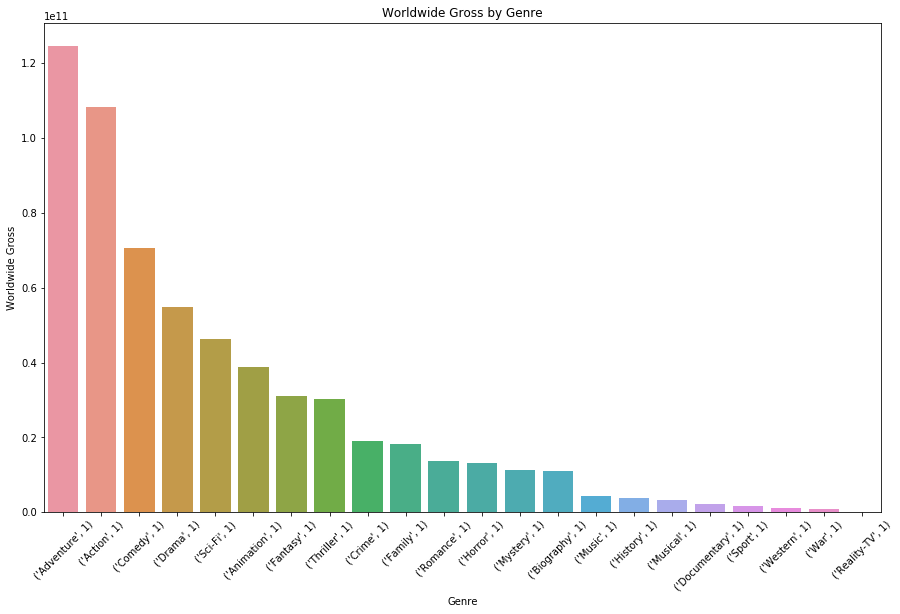

In [6]:
plt.figure(figsize=(15,9))
sns.barplot(df_temp.index, df_temp.worldwideGross)
plt.xlabel("Genre")
plt.ylabel("Worldwide Gross")
plt.title("Worldwide Gross by Genre")
plt.xticks(rotation=45)
plt.show()

Adventure and Action films far outrank other genres at the box office.

What if we wanted to measure this on a per movie basis?

In [7]:
data = {'genre': list(all_genres), 'movies': None}
genre_movies = pd.DataFrame(data)
genre_movies = genre_movies.set_index('genre')
for i in all_genres:
    genre_movies['movies'][i] = df[i].sum()
genre_movies

df_temp = df_temp.join(genre_movies, how='inner', on='genre')
df_temp['per_movie'] = df_temp.worldwideGross / df_temp.movies
df_temp = df_temp.sort_values(by='per_movie', ascending=False)

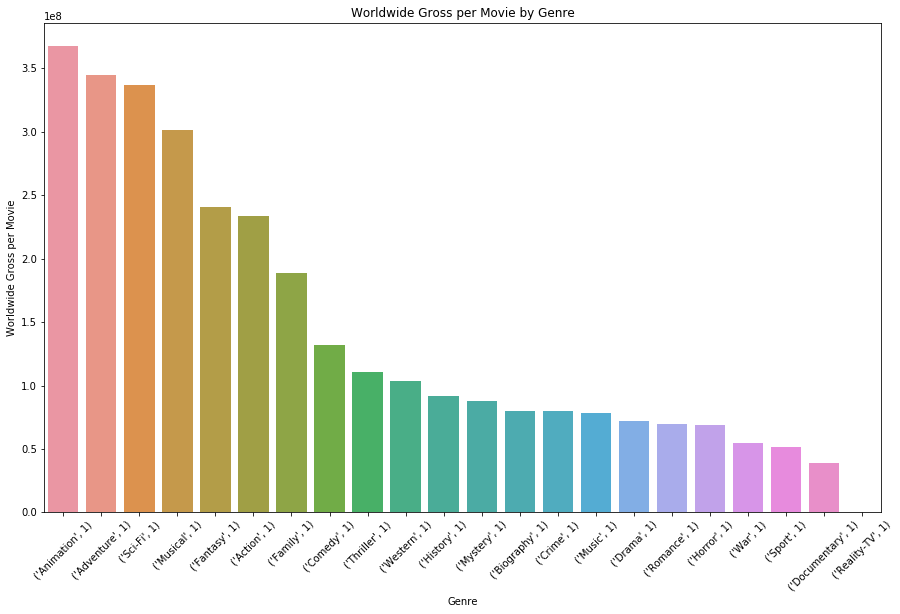

In [8]:
plt.figure(figsize=(15,9))
sns.barplot(df_temp.index, df_temp.per_movie)
plt.xlabel("Genre")
plt.ylabel("Worldwide Gross per Movie")
plt.title("Worldwide Gross per Movie by Genre")
plt.xticks(rotation=45)
plt.show()

Here we see that on a per-movie basis, Adventure is still among the highest grossing. However, Animation and Sci-Fi have now also skyrocketed to being top performers.

## Release Month (John)

*What is the impact of release month on box office sales?*

Which release month makes the most at the box office?

In [1]:
df = pd.read_sql_query('''
    SELECT SUBSTRING(release_date, 1, 4) AS release_month,
           count(id) AS movies_released,
           CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS productionBudget, 
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) AS worldwideGross,
           CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS domesticGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS internationalGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) / count(id) AS gross_per_movie
           -- CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS profit
    FROM tn_movie_budgets
    GROUP BY release_month
    ORDER BY worldwideGross DESC
''', conn)

NameError: name 'pd' is not defined

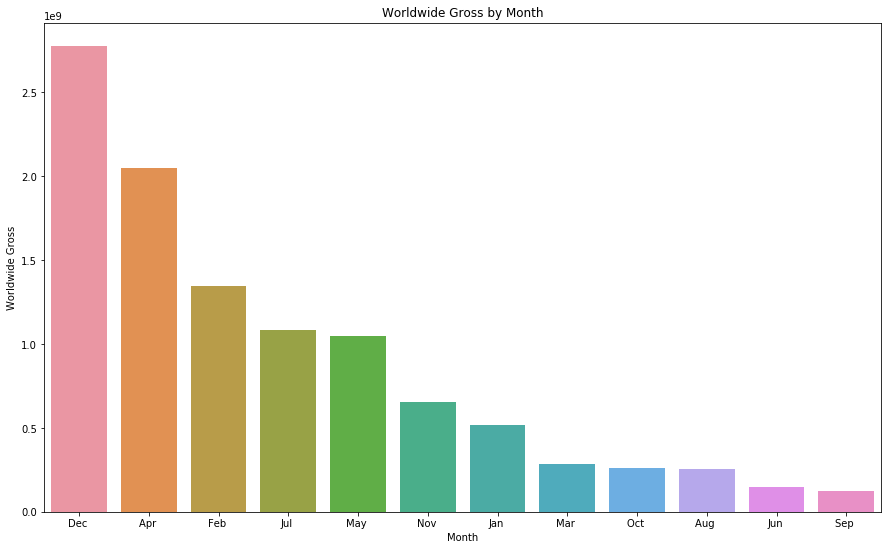

In [10]:
plt.figure(figsize=(15,9))
sns.barplot(x=df['release_month'], y=df['worldwideGross'])
plt.title("Worldwide Gross by Month")
plt.xlabel("Month")
plt.ylabel("Worldwide Gross")
plt.show()

December-released movies make the most money by far, followed by April and then February. This makes sense given the winter holiday season in December, the spring holiday season in April, and Valentine's Day in February.

Does the answer change if we examine box office results on a per-movie basis?

In [11]:
df = pd.read_sql_query('''
    SELECT SUBSTRING(release_date, 1, 4) AS release_month,
           count(id) AS movies_released,
           CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS productionBudget, 
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) AS worldwideGross,
           CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS domesticGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS internationalGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) / count(id) AS gross_per_movie
           -- CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS profit
    FROM tn_movie_budgets
    GROUP BY release_month
    ORDER BY gross_per_movie DESC
''', conn)

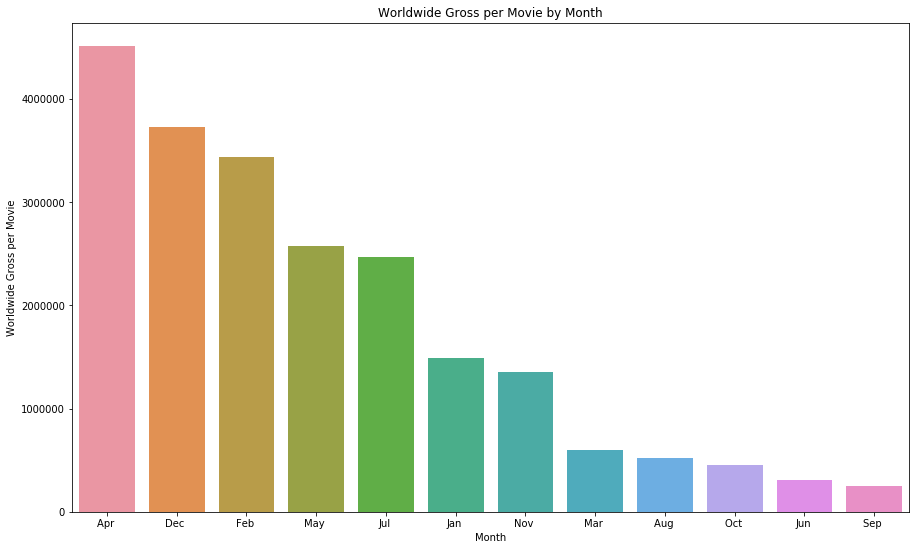

In [12]:
plt.figure(figsize=(15,9))
sns.barplot(x=df['release_month'], y=df['gross_per_movie'])
plt.title("Worldwide Gross per Movie by Month")
plt.xlabel("Month")
plt.ylabel("Worldwide Gross per Movie")
plt.show()

In fact, April, December, and February retain their top spots as having the highest grossing movies on a per-movie basis.

## Success by Director (Carmi)

*Who are the most successful directors according to box office sales?*

In [6]:
df2=pd.read_sql('''Select primary_name,primary_profession,movie,production_budget,domestic_gross,worldwide_gross
From movies.imdb_title_crew
join imdb_name_basics
on imdb_name_basics.nconst = imdb_title_crew.directors
join imdb_title_basics
on imdb_title_basics.tconst = imdb_title_crew.tconst
join tn_movie_budgets
on imdb_title_basics.primary_title=tn_movie_budgets.movie
where primary_profession like "%director%"''',conn)

In [7]:
df2['worldwide_gross']=df2['worldwide_gross'].str.replace(',','')
df2['worldwide_gross']=df2['worldwide_gross'].str.replace('$','')
df2['worldwide_gross'] = df2.worldwide_gross.astype(float)

In [8]:
g=df2[['primary_name','worldwide_gross']]

In [9]:
gbd = g.groupby('primary_name').sum().sort_values('worldwide_gross',ascending=False).head(20)

Text(0.5, 1.0, 'Top 20 Most Successful Directors')

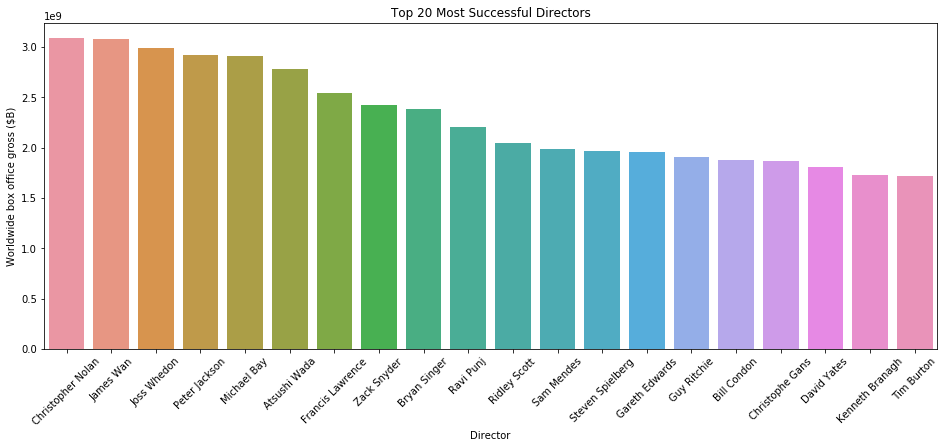

In [11]:
plt.figure(figsize=(16, 6))
sns.barplot(gbd.index,gbd.worldwide_gross)
plt.xlabel('Director')
plt.ylabel('Worldwide box office gross ($B)')
plt.xticks(rotation=45)
plt.title('Top 20 Most Successful Directors')